# Poisson regression (GAM) COVID-19 Prediction

In [159]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import preprocess_data, StemPoissonRegressor, StemPoissonRegressorCombined
from utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [160]:
# # Read in data
active_cases_provinces = get_all_covid_data(level='prov', preprocess=True)

# Remove outlier for quebec
active_cases_provinces.loc[active_cases_provinces['removed'] == 23687, 'removed'] = 1

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0       0          0   
1                  0             0                    0       0          0   
2                  0             0                    0       0          0   
3                  0             0                    0       0          0   
4                  0             0                    0       0          0   
5                  0             0                    0       0          0   
6                  0             0                    0       0          0   
7                  0             0                    0       0          0   
8                  0             0                    0       0          0   
9                  0             0                    0       0          0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876        0      4421876                  1.0  
1      0     4421876        0      4421876                  1.0  
2      0     4421876        0      4421876                  1.0  
3      0     4421876        0      4421876                  1.0  
4      0     4421876        0      4421876                  1.0  
5      0     4421876        0      4421876                  1.0  
6      0     4421876        0      4421876                  1.0  
7      0     4421876        0      4421876                  1.0  
8      0     4421876        0      4421876                  1.0  
9      0     4421876        0      4421876                  1.0

In [161]:
# Remove data before March 8
remove_date = date(day=8, month=3, year=2020)
active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

# Ignore provinces with very little cases
provinces_ignore = ['PEI', 'New Brunswick', 'NWT', 'NL', 'Nova Scotia', 'Nunavut', 'Yukon']
active_cases_provinces = active_cases_provinces.query("province not in @provinces_ignore").reset_index(drop=True)

provinces = active_cases_provinces['province'].unique()

### Comments

- Mortality data starts March 8, 2020 so we will just ignore all dates before March 1. 

## Poisson regression

We'll be applying a similar but simpler version of the poisson regression as proposed in the paper mentioned above. Currently it only accounts for temporal effects. For a given province $i$ we have the new cases modelled as 

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and the new deaths/recovered modelled as 

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

In [138]:
# Preprocess all province data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

In [139]:
# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()

for province in provinces:
    # Get province data
    province_data = active_cases_provinces_preprocessed.query('province == @province')
    X = province_data
    Y = province_data[['province', 'date', 'cases', 'removed']]
    
    # Fit model
    model = StemPoissonRegressor()
    model.fit(X, Y)
    
    # Get forecasts
    province_forecasts = model.forecast(h=h)
    province_forecasts = province_forecasts.merge(province_data, how='left', on=['province', 'date'])
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)

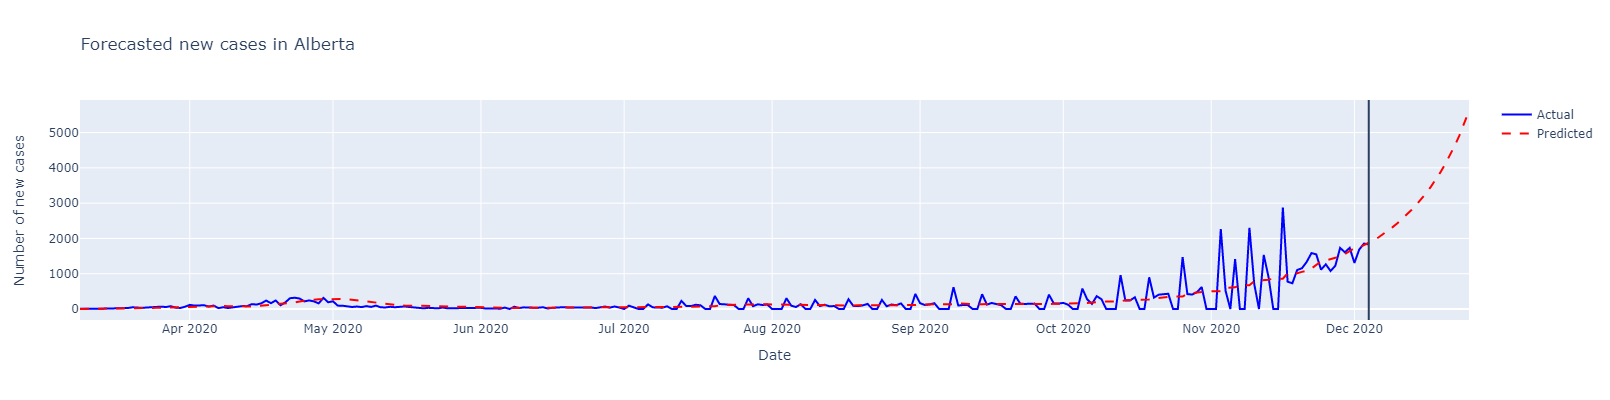

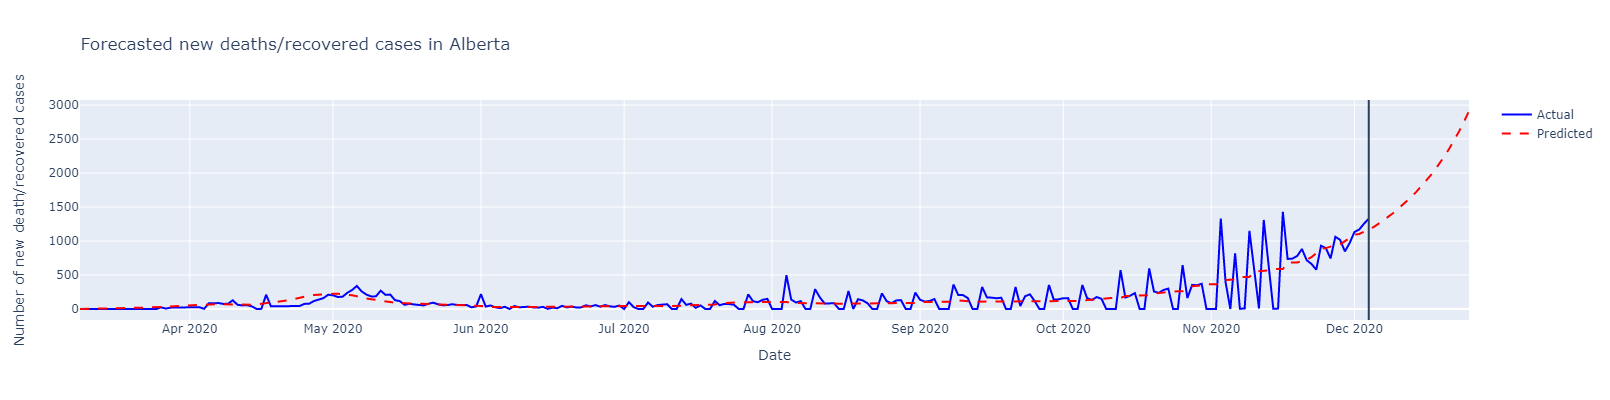

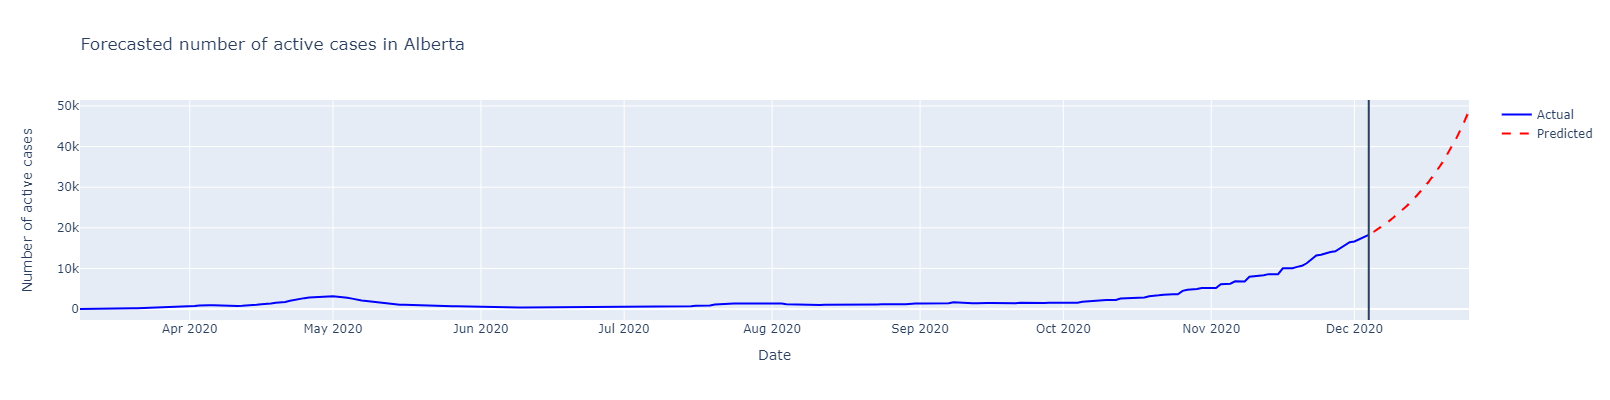

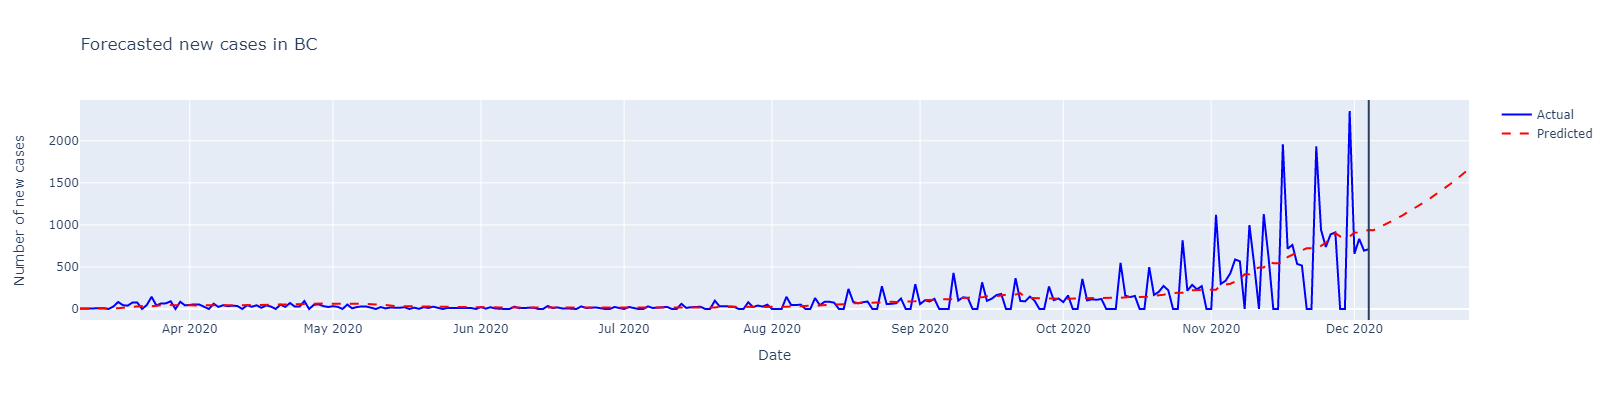

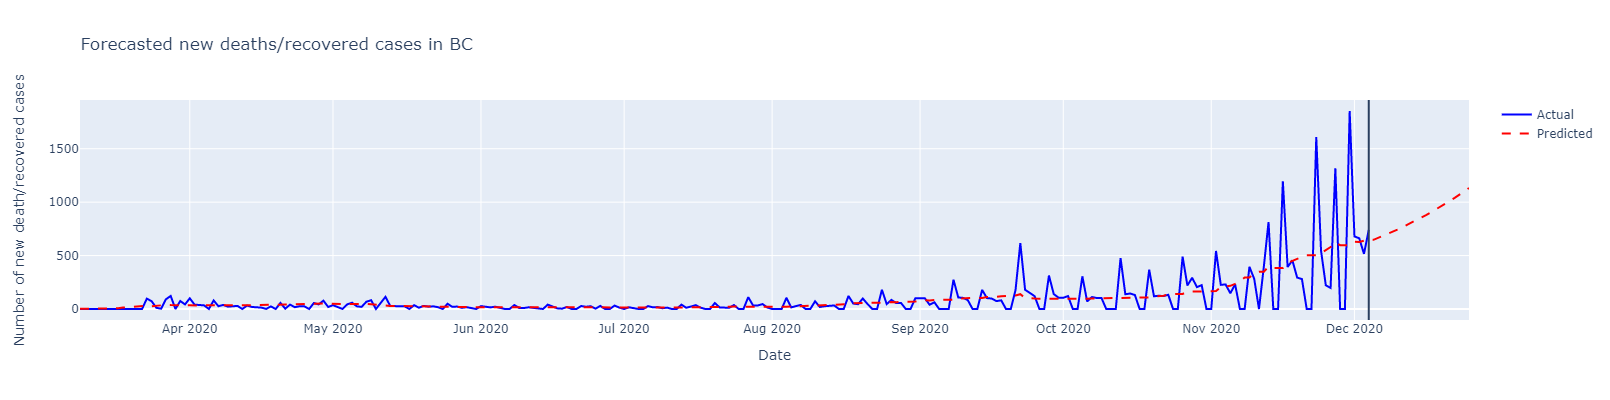

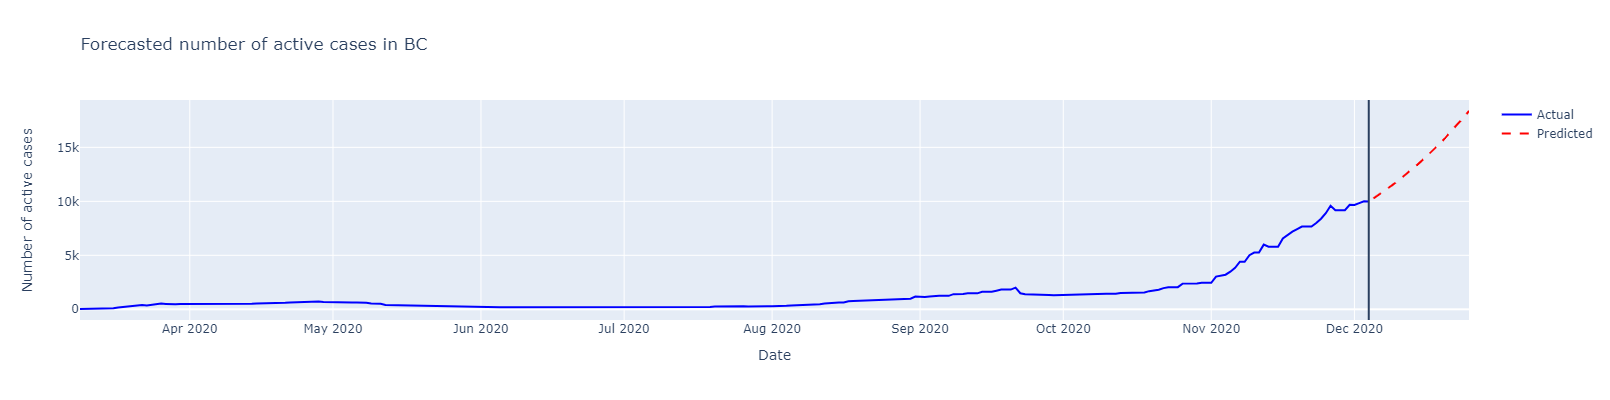

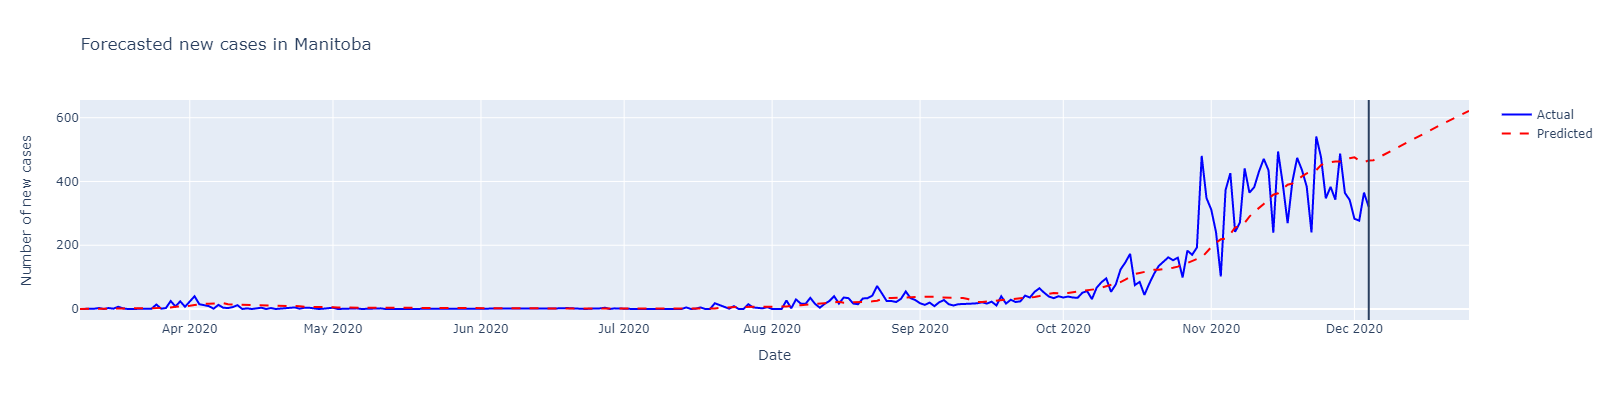

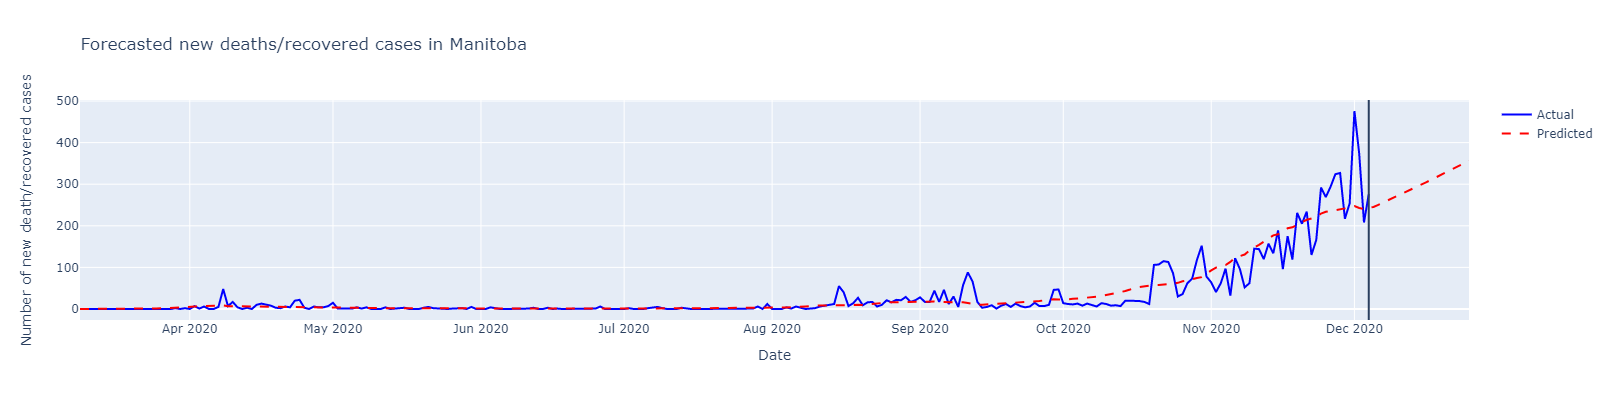

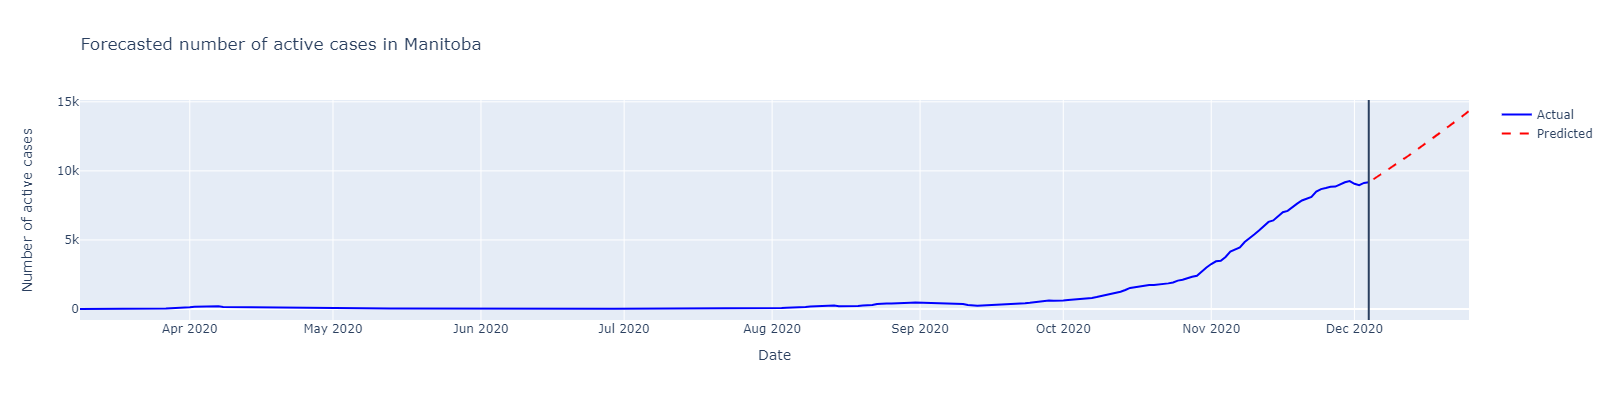

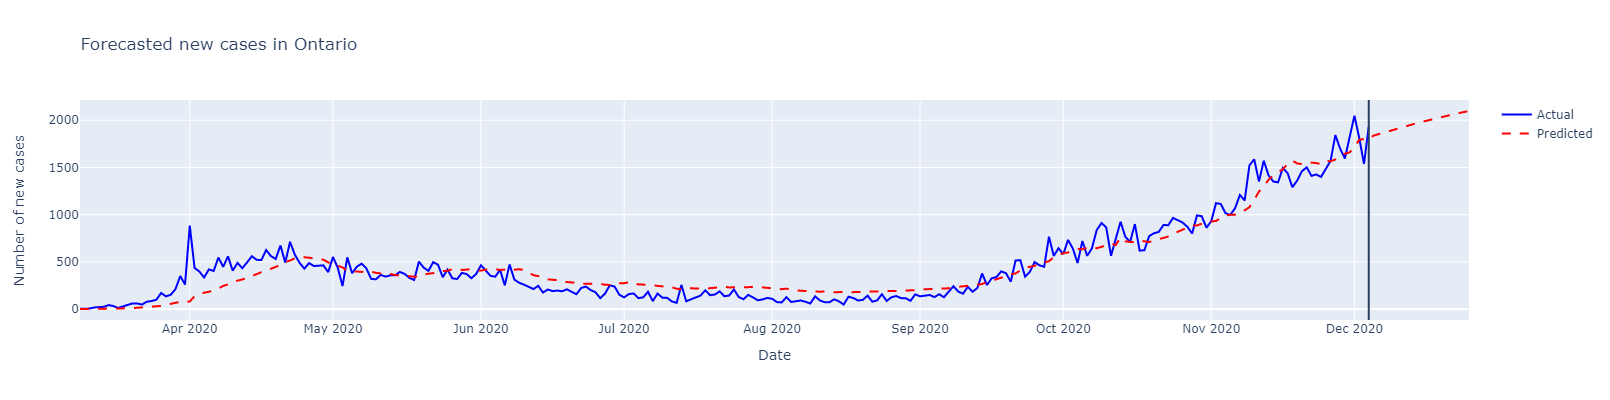

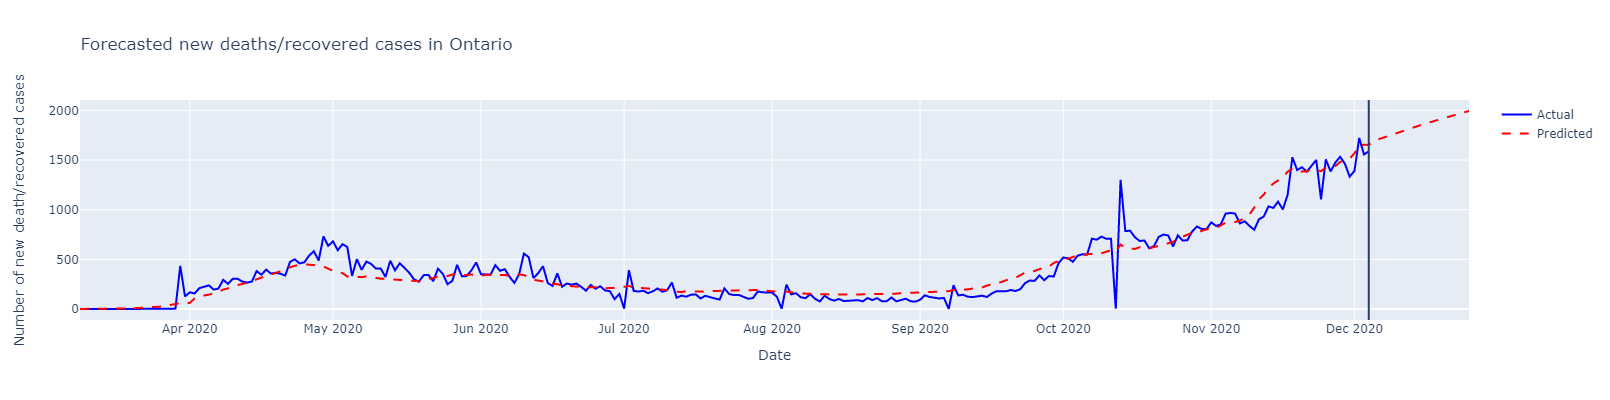

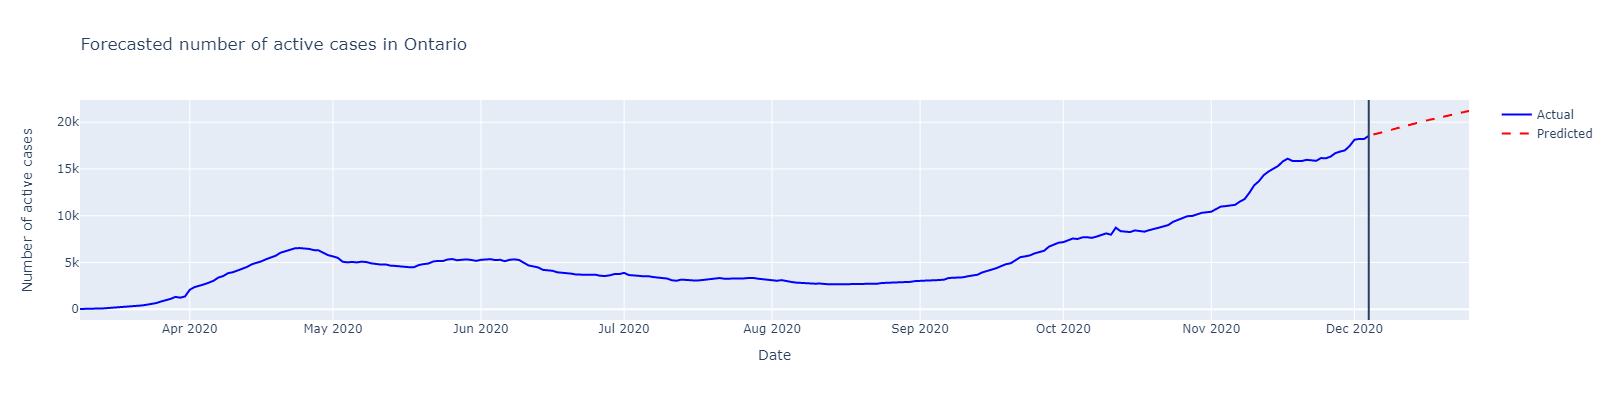

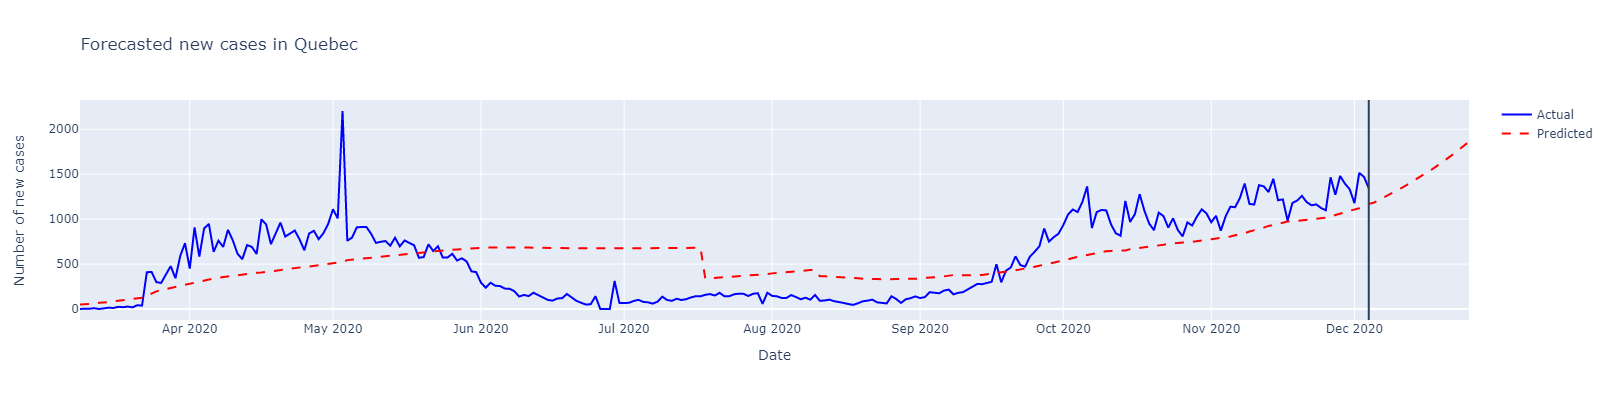

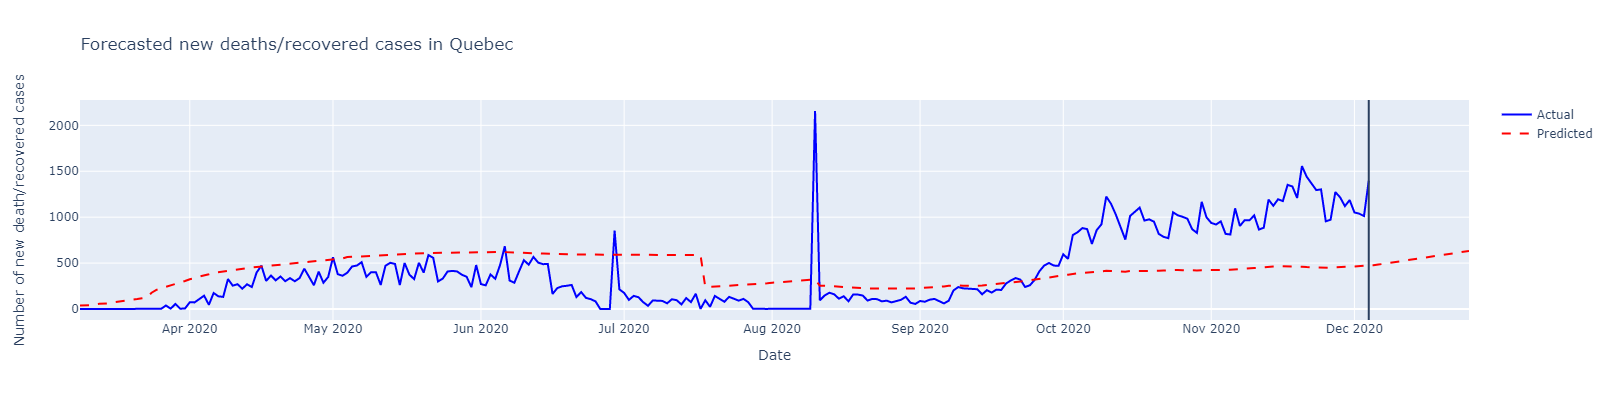

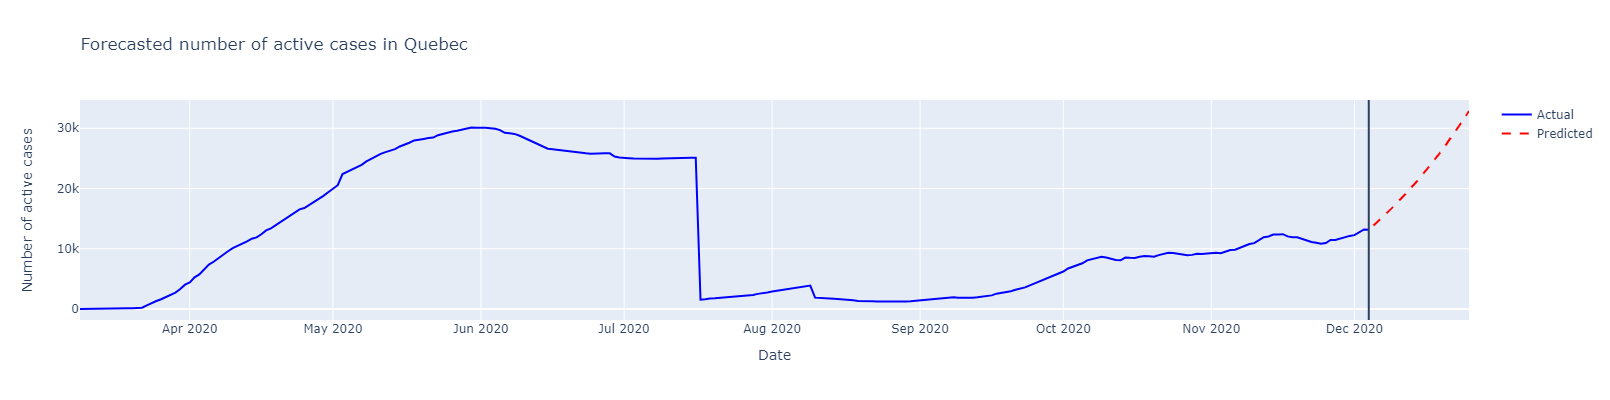

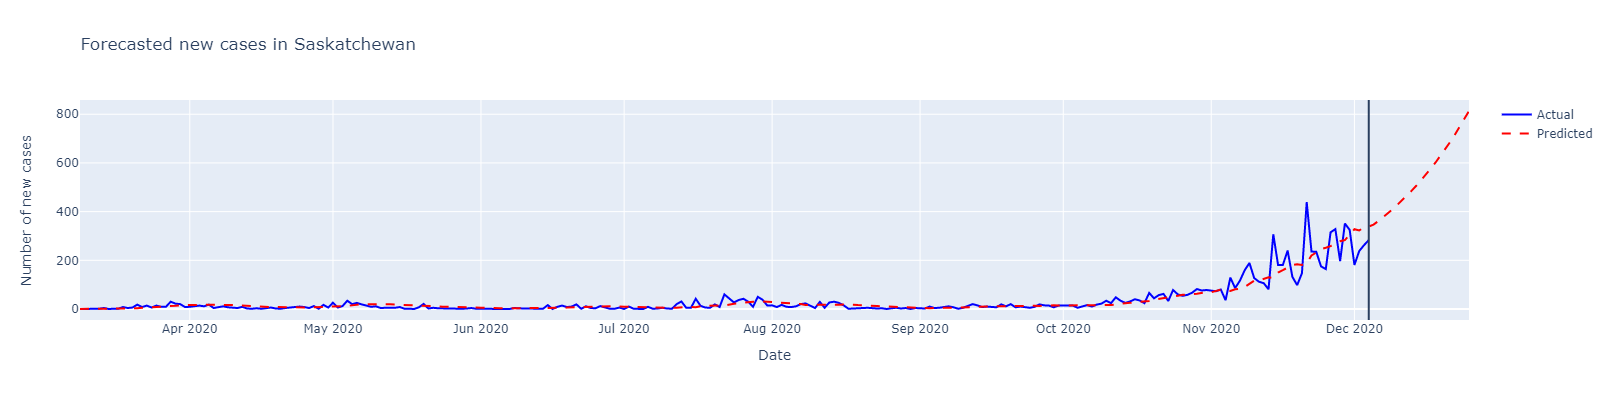

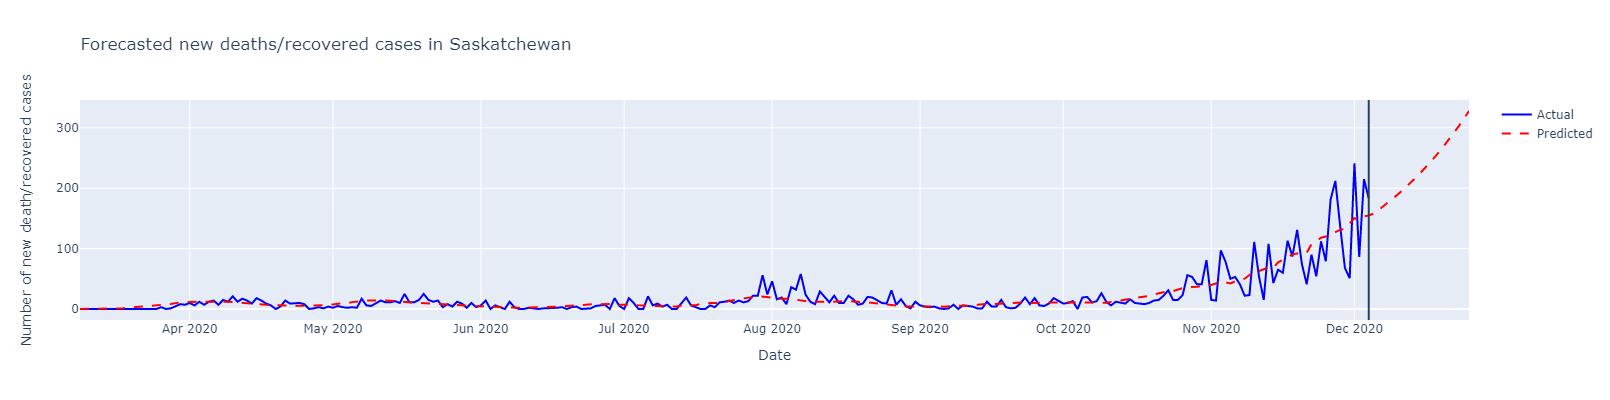

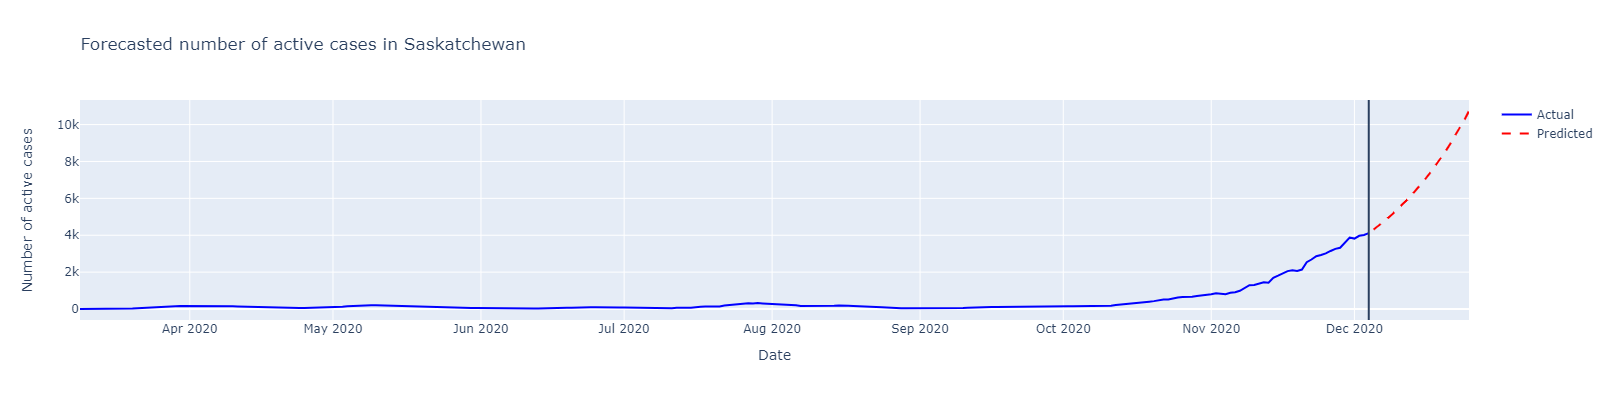

In [140]:
# Prediction plots for all provinces
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Comments
- Overall the forecasts and fitted curves seem to fit the actual data ok. Though for some provinces it seems like the forecasts are too high for active cases and new removed cases
- For quebec there's huge drop in predicted cases on July 18 most likely caused from the huge drop in active cases in Quebec. The noise in the data is effecting the performance of the model too much

## Poisson regression Combined Model

Similar to the above model. The combined poisson regression model has all province temporal variables as predictors. For example, for Ontario we use previous day information for Ontario as well as Alberta, BC, Manitoba, etc in order to predict the next day new cases and new removed. For Ontario for example, we model the new cases as 

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{BC, t-1} + 1) + \alpha_tlog(S_{BC, t-1}/N) + \beta_{2t}log(I_{QC, t-1} + 1) + \alpha_tlog(S_{QC, t-1}/N) + ...
$$

and the model for new removed cases as

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{BC, t-1} + 1) + \beta_{2t}^D log(I_{QC, t-1} + 1) + ...
$$

For the variables corresponding to all other provinces than current one in model we also place higher regularization on those parameters so the variables relating to the given province have higher effect.

In [141]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, add_province_columns=True, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

In [142]:
# Fit model
model = StemPoissonRegressorCombined(lam_main=0.6, lam_other=100)
model.fit(X, Y)

In [143]:
# Get 3 week forecasts
forecasts = model.forecast(h=21)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred   cases_pred  removed_pred  \
1742      Manitoba  2020-12-24        9168.444183   391.670628    391.882130   
1743       Ontario  2020-12-24       18444.583467  1720.108310   1727.600168   
1744        Quebec  2020-12-24       12823.798735  1539.392149   1563.965236   
1745  Saskatchewan  2020-12-24        4116.640659   335.386115    335.415195   
1746       Alberta  2020-12-25       18248.779005  1712.936725   1712.489455   
1747            BC  2020-12-25        9981.987469   861.336705    861.411921   
1748      Manitoba  2020-12-25        9168.223834   391.729136    391.949485   
1749       Ontario  2020-12-25       18436.811549  1717.984931   1725.756848   
1750        Quebec  2020-12-25       12798.354467  1536.568469   1562.012738   
1751  Saskatchewan  2020-12-25        4116.610398   335.431138    335.461399   

     is_forecast  cumulative_cases  cumulative_recovered  cumulative_deaths  \
1742        True               NaN                   NaN                NaN   
1743        True               NaN                   NaN                NaN   
1744        True               NaN                   NaN                NaN   
1745        True               NaN                   NaN                NaN   
1746        True               NaN                   NaN                NaN   
1747        True               NaN                   NaN                NaN   
1748        True               NaN                   NaN                NaN   
1749        True               NaN                   NaN                NaN   
1750        True               NaN                   NaN                NaN   
1751        True               NaN                   NaN                NaN   

      active_cases  active_cases_change  deaths  recovered  cases  population  \
1742           NaN                  NaN     NaN        NaN    NaN         NaN   
1743           NaN                  NaN     NaN        NaN    NaN         NaN   
1744           NaN                  NaN     NaN        NaN    NaN         NaN   
1745           NaN                  NaN     NaN        NaN    NaN         NaN   
1746           NaN                  NaN     NaN        NaN    NaN         NaN   
1747           NaN                  NaN     NaN        NaN    NaN         NaN   
1748           NaN                  NaN     NaN        NaN    NaN         NaN   
1749           NaN                  NaN     NaN        NaN    NaN         NaN   
1750           NaN                  NaN     NaN        NaN    NaN         NaN   
1751           NaN                  NaN     NaN        NaN    NaN         NaN   

      removed  susceptible  percent_susceptible  
1742      NaN          NaN                  NaN  
1743      NaN          NaN                  NaN  
1744      NaN          NaN                  NaN  
1745      NaN          NaN                  NaN  
1746      NaN          NaN                  NaN  
1747      NaN          NaN                  NaN  
1748      NaN          NaN                  NaN  
1749      NaN          NaN                  NaN  
1750      NaN          NaN                  NaN  
1751      NaN          NaN                  NaN

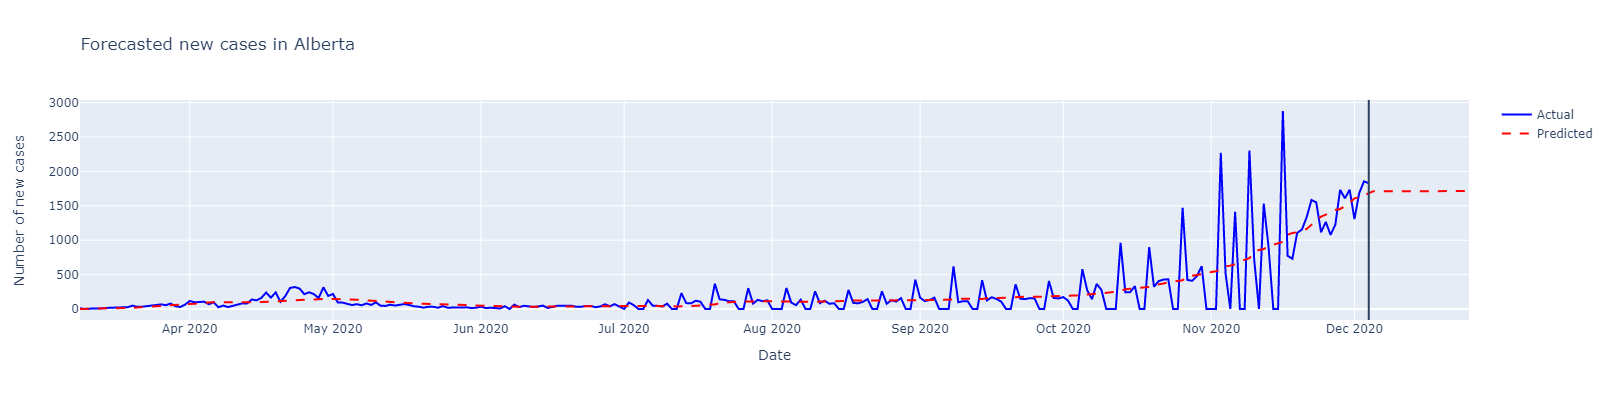

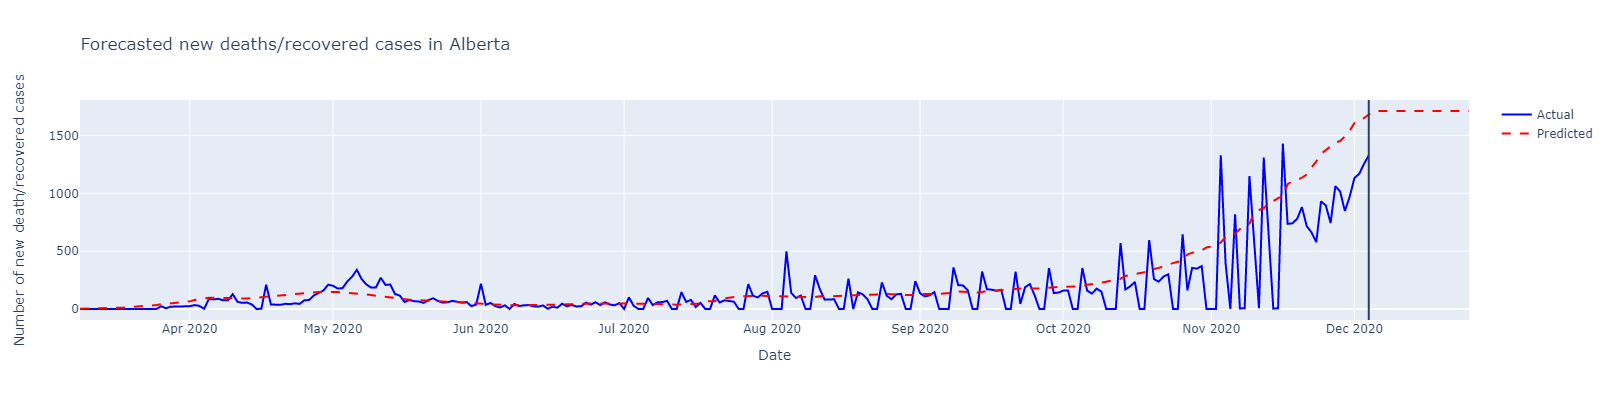

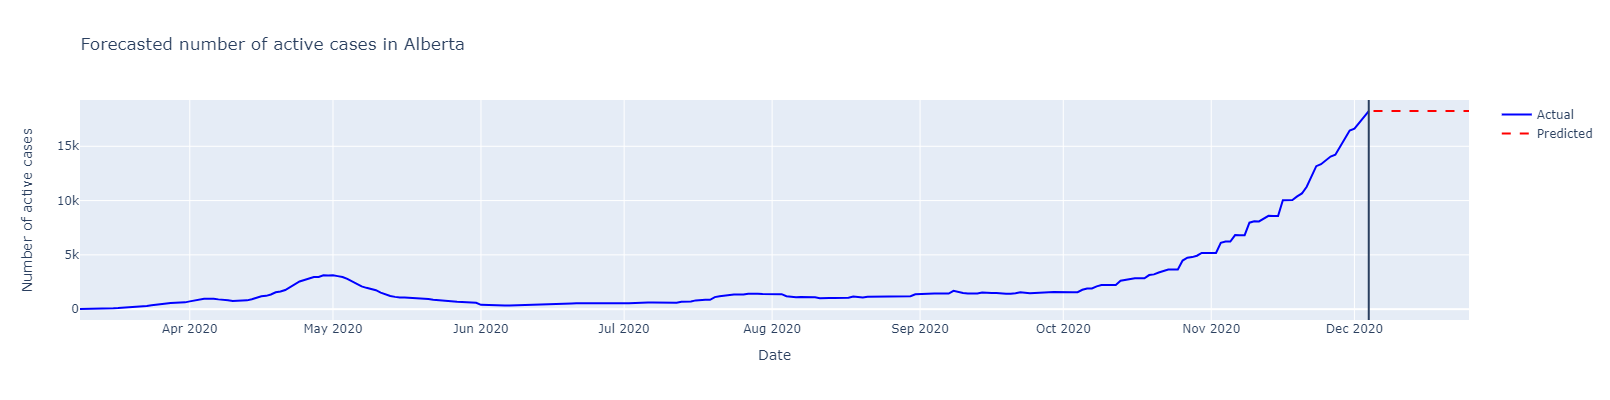

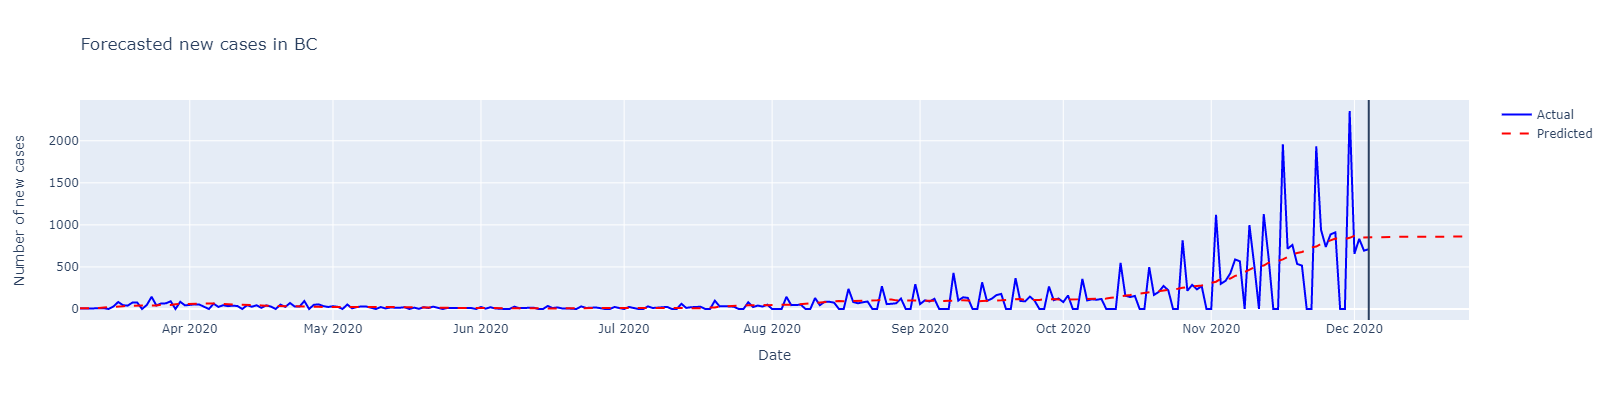

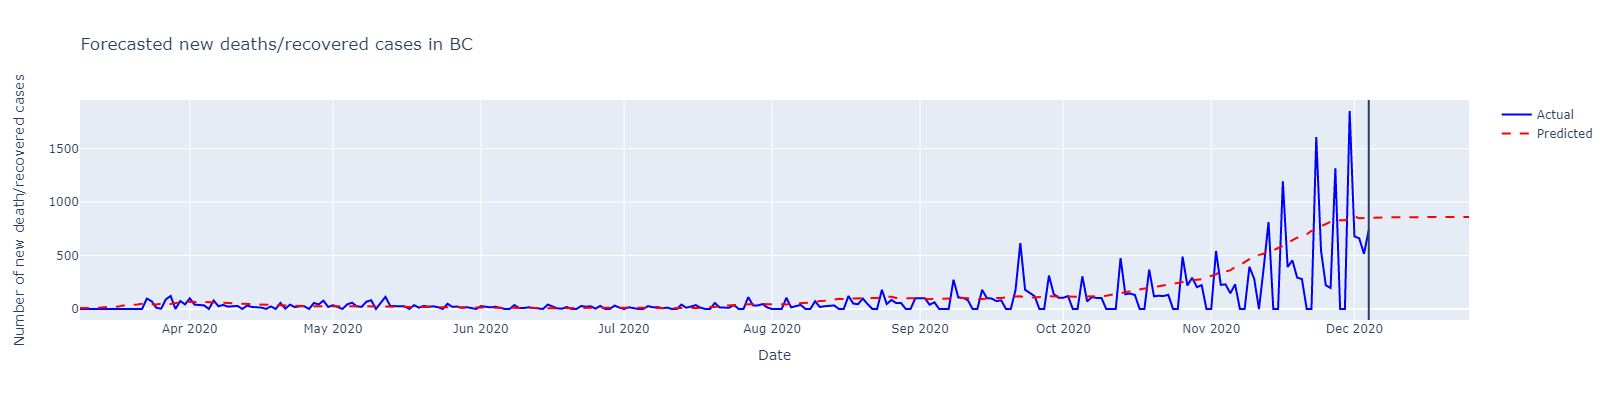

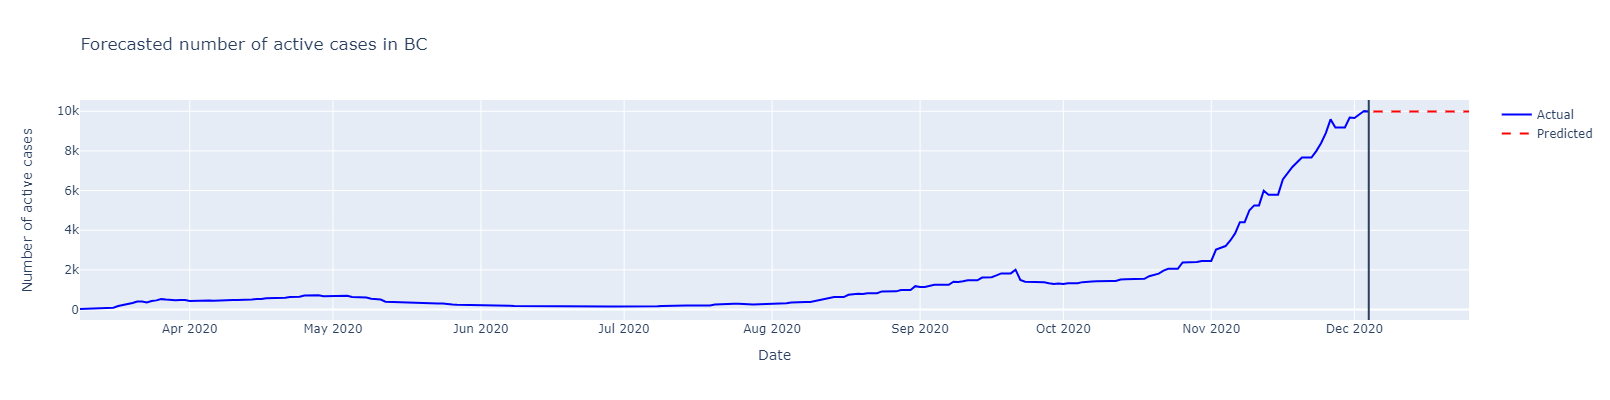

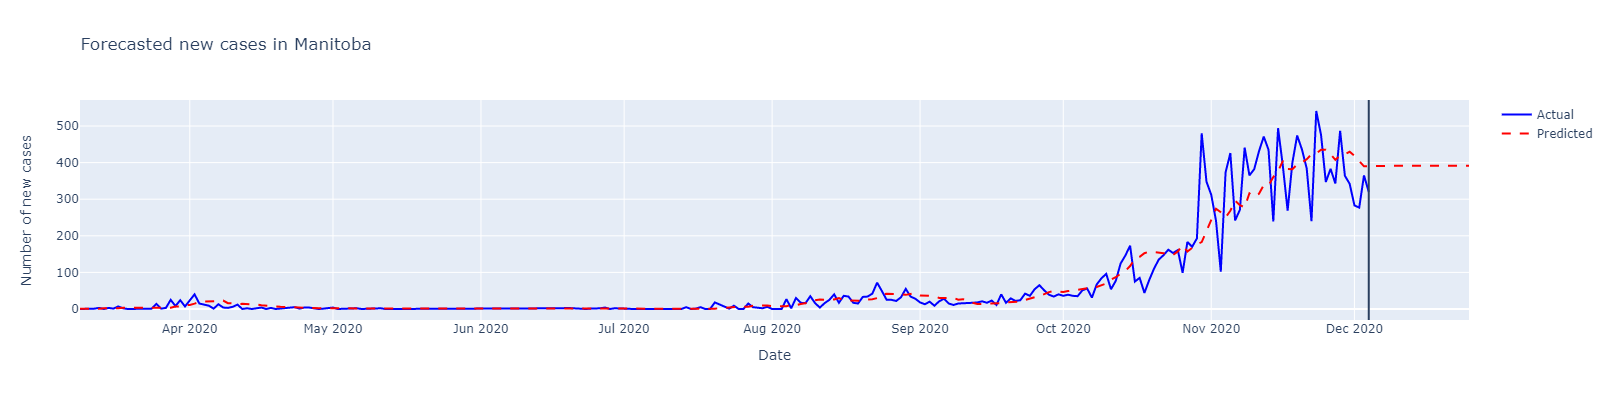

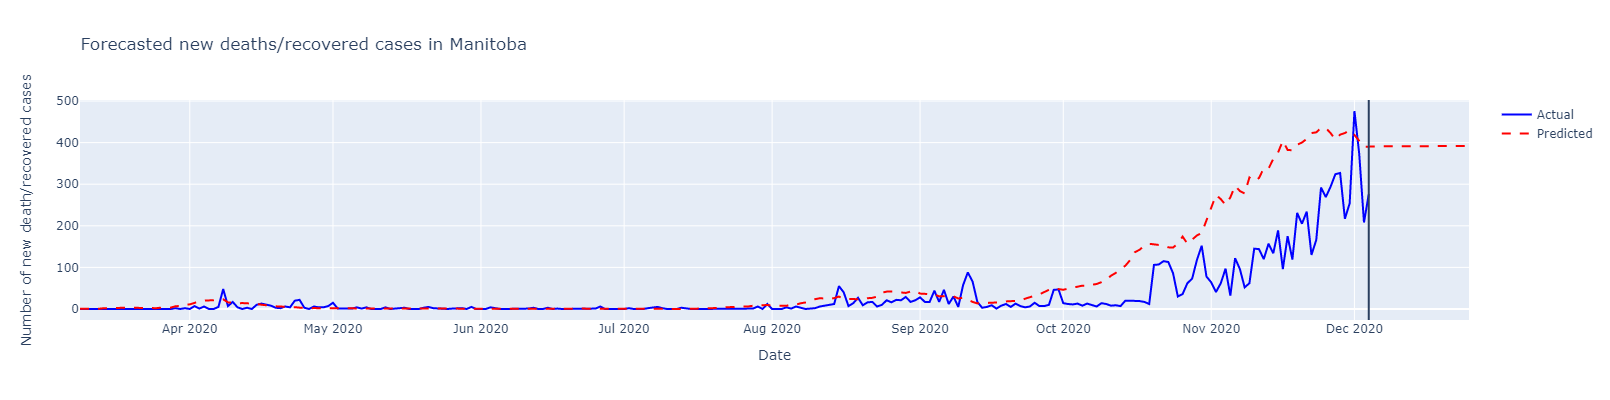

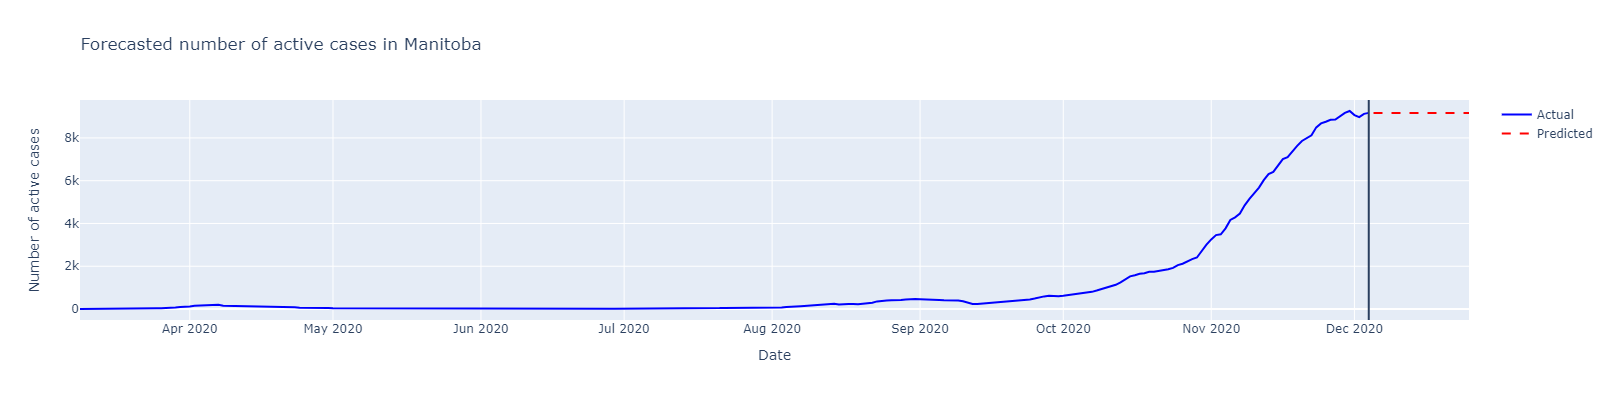

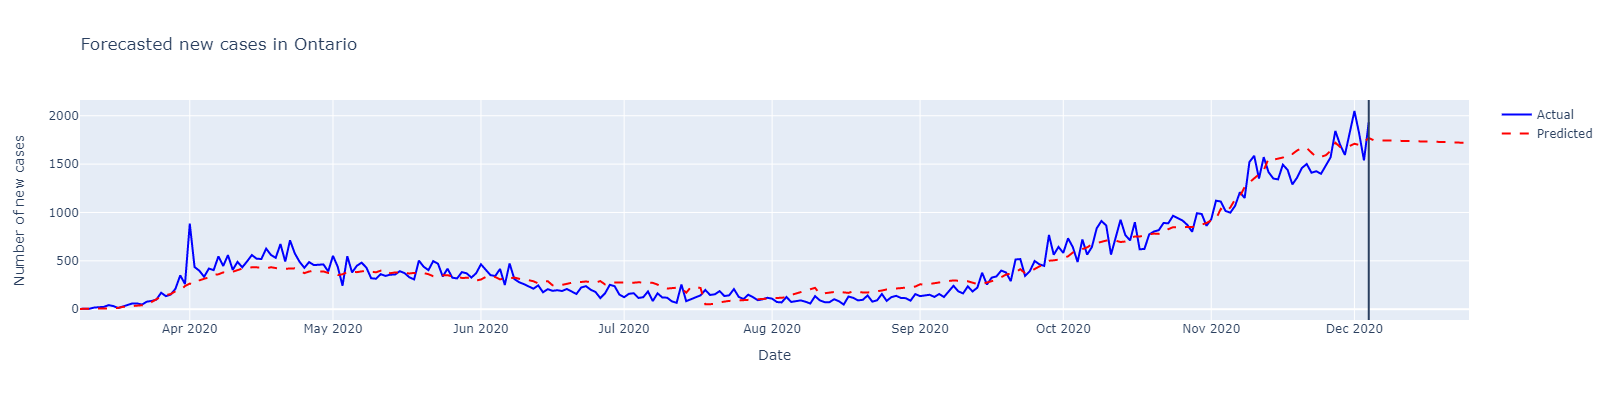

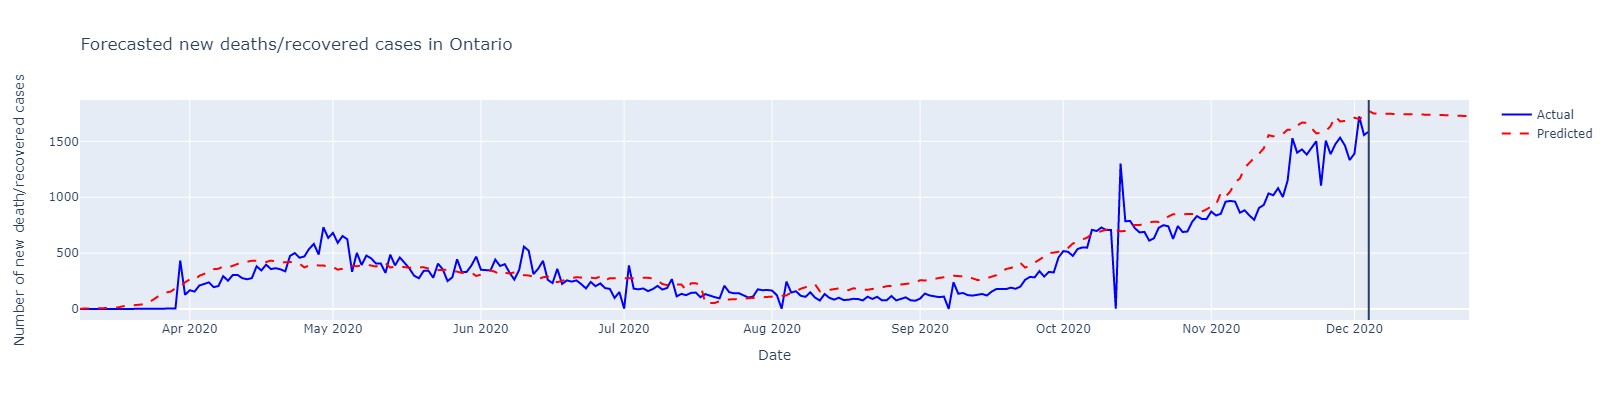

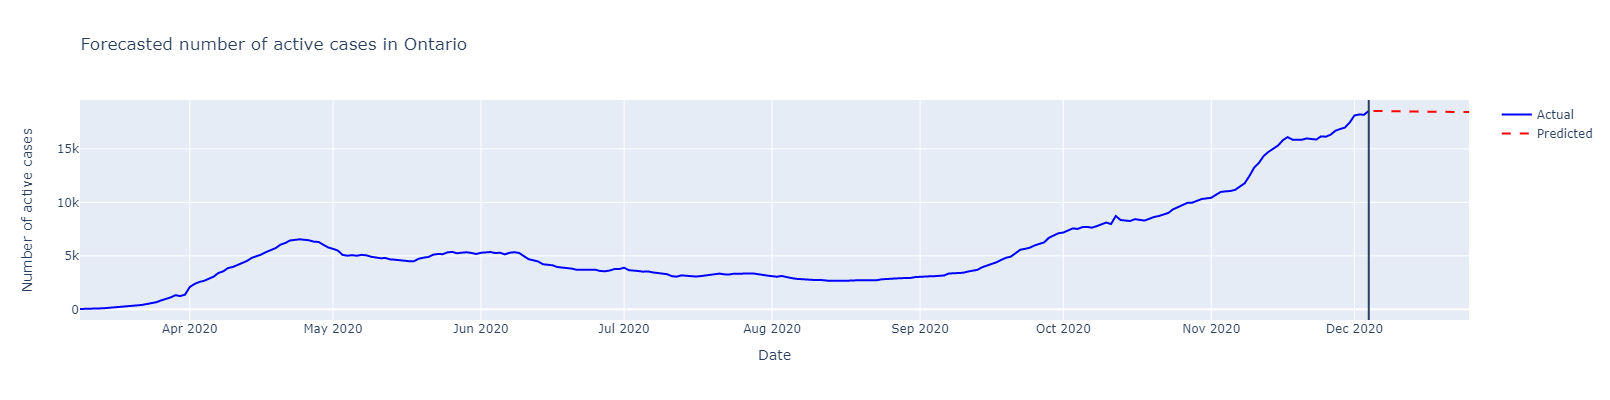

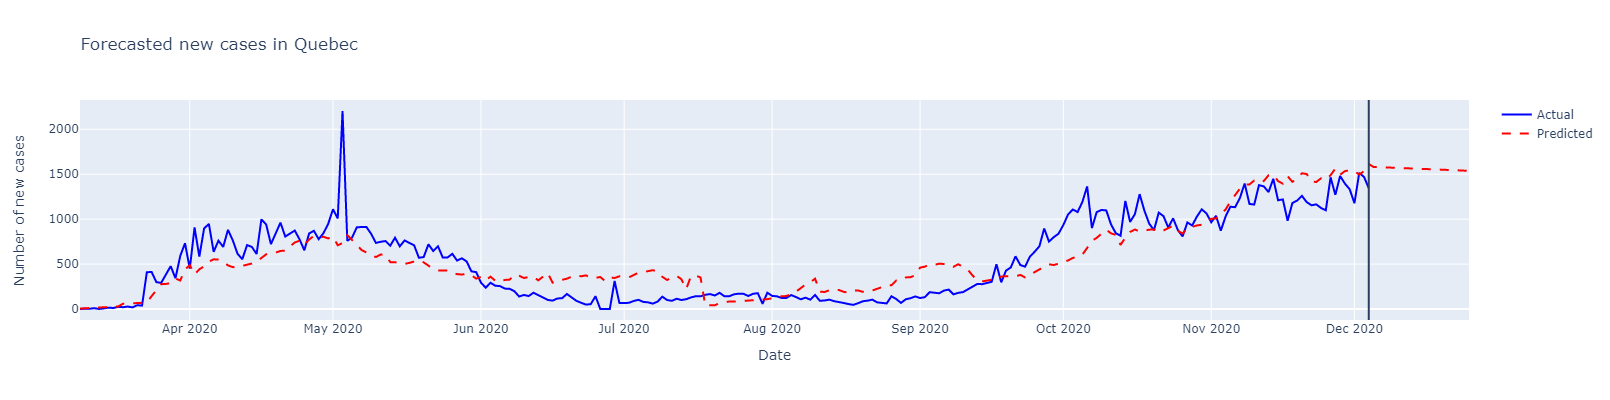

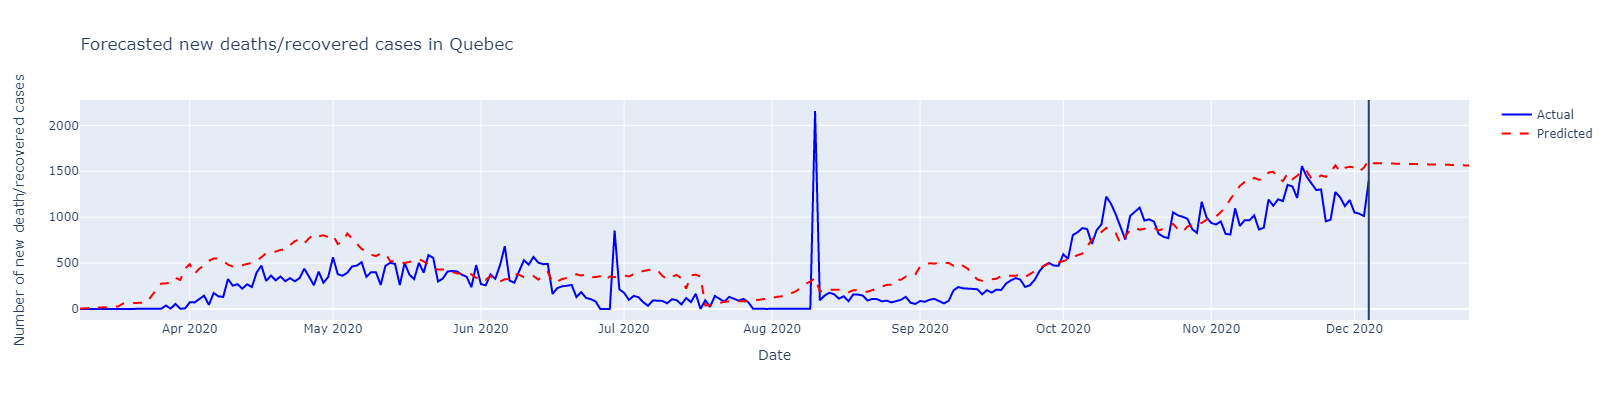

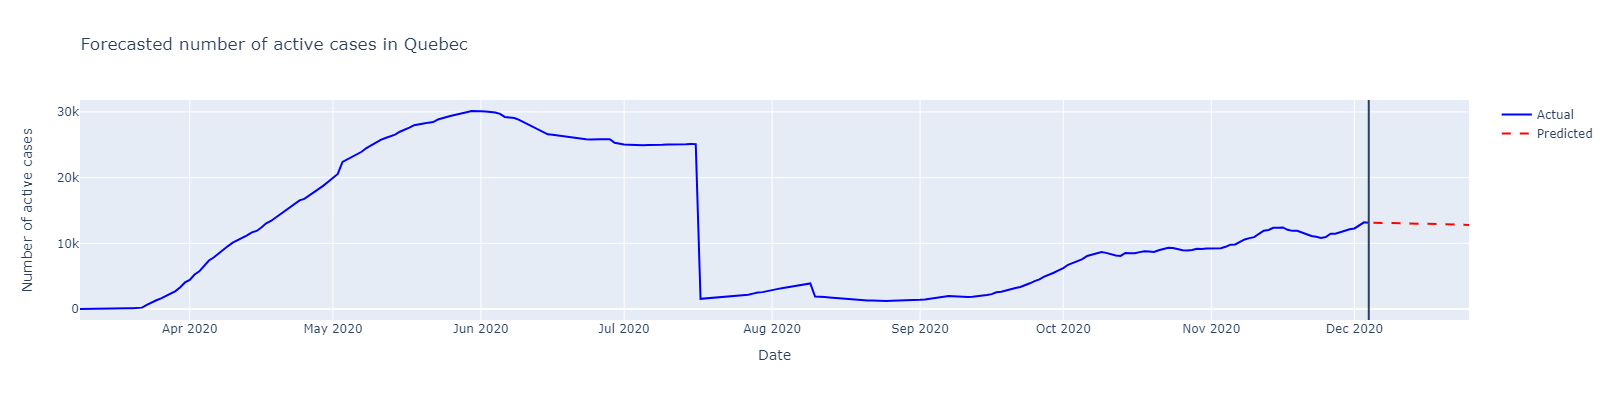

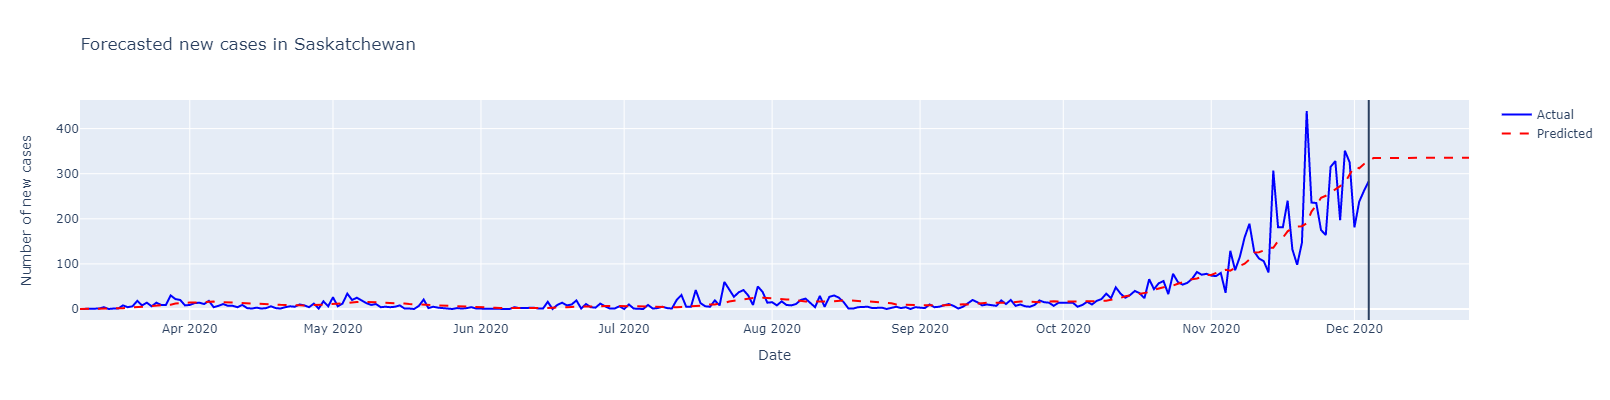

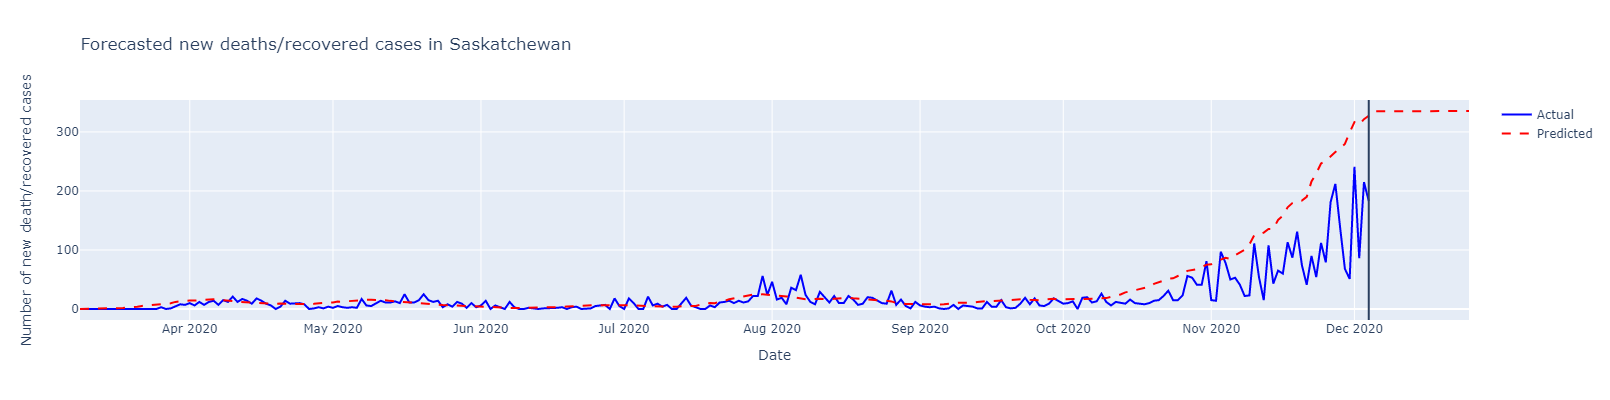

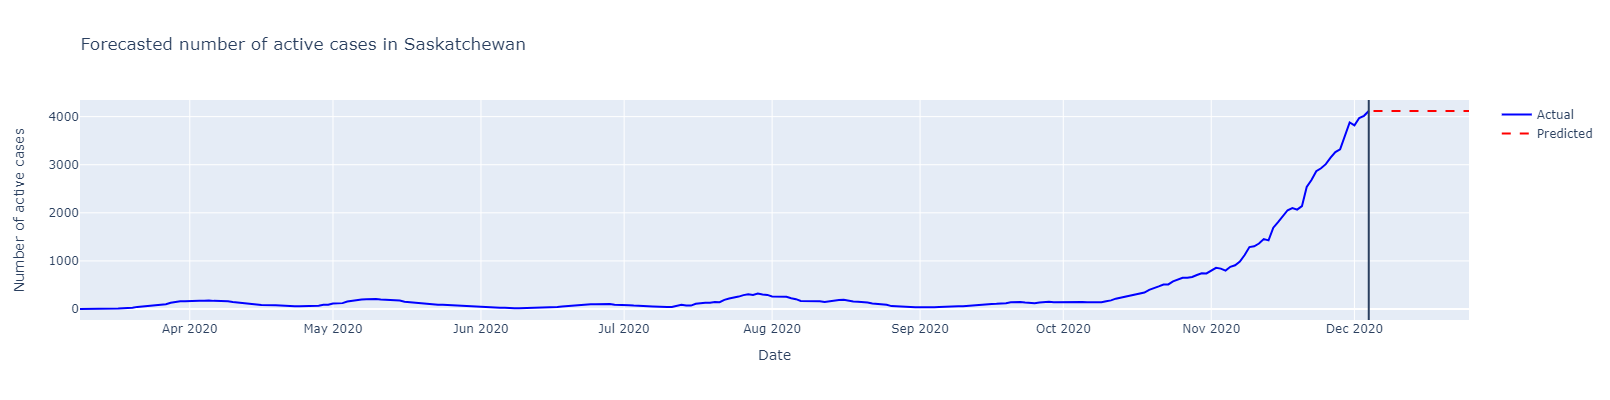

In [144]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Comments
- Compared to the single model case these ones give very flat forecasts
- Coefficients for all provinces for a given model are significant and their magnitude is just as large as the coefficient for the given province. This could be that the province data follow similar patterns, not linearly independent data, which can explain these results

## Cross validation

In [145]:
# Dataframe to store cross validation scores
cv_scores = pd.DataFrame(columns=["province", "method", "fold", "rmse"])

### Poisson regression

In [146]:
%%time

# Preprocess all province data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    province_data = active_cases_provinces_preprocessed.query('province == @province')
    
    for index, (train_index, test_index) in enumerate(tscv.split(province_data)):
        # Split data into train and test
        data_train, data_test = province_data.iloc[train_index], province_data.iloc[test_index]
        X_train, Y_train = data_train, data_train[['province', 'date', 'cases', 'removed']]
        Y_test = data_test[['province', 'date', 'cases', 'removed']]

        # Fit model to train set
        model = StemPoissonRegressor()
        model.fit(X_train, Y_train)        

        # Calculate test fold rmse for both cases and removed
        province_forecasts = model.forecast(h = test_index.shape[0]).iloc[test_index]
        cases_rmse = mean_squared_error(province_forecasts['cases_pred'], Y_test['cases'], squared=False)
        removed_rmse = mean_squared_error(province_forecasts['removed_pred'], Y_test['removed'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'poisson_reg_linear', 'response': 'cases', 'fold': index, 'rmse': cases_rmse}, ignore_index=True)
        cv_scores = cv_scores.append({'province': province, 'method': 'poisson_reg_linear', 'response': 'removed', 'fold': index, 'rmse': removed_rmse}, ignore_index=True)        

Wall time: 20.3 s


In [147]:
# Average rmse scores
cv_scores.query('method == "poisson_reg_linear"').groupby(["province", 'response']).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province response        rmse                                     
                                 mean         std         min          max
0        Alberta    cases  241.021577  237.780143   48.789199   743.508293
1        Alberta  removed  143.093026  114.869237   34.499303   380.891707
2             BC    cases  190.486252  322.780609   16.809408  1058.113740
3             BC  removed  113.452779  161.510364   13.549859   546.304849
4       Manitoba    cases   97.534186  224.634886    1.590191   732.060461
5       Manitoba  removed   19.088458   21.219945    1.641685    64.625011
6        Ontario    cases  285.448520  132.565249  104.568185   513.814079
7        Ontario  removed  202.700880   91.777326   72.726643   364.966902
8         Quebec    cases  508.064637  232.798392  157.518932   776.950161
9         Quebec  removed  416.317845  218.896647  115.180923   804.111636
10  Saskatchewan    cases   30.779141   46.709926    5.416769   152.486830
11  Saskatchewan  removed   15.607761   17.178040    4.724223    58.293260

### Poisson Regression Combined

In [148]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, add_province_columns=True, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

In [149]:
%%time

tscv = TimeSeriesSplit(n_splits=10)
dates = active_cases_provinces_preprocessed['date'].unique()

# loop through each province and each split based on dates
for index, (train_index, test_index) in enumerate(tscv.split(dates)):
    dates_train, dates_test = dates[train_index], dates[test_index]
    
    # Split data into train and test
    X_train, Y_train = X.query('date in @dates_train'), Y.query('date in @dates_train')
    Y_test = Y.query('date in @dates_test')

    # Fit model to train 
    model = StemPoissonRegressorCombined(lam_main=0.6, lam_other=100)
    model.fit(X_train, Y_train)        

    # Calculate test fold rmse for both cases and removed for each province
    forecasts = model.forecast(h = test_index.shape[0]).query('date in @dates_test')
    
    for province in provinces:
        province_forecasts = forecasts.query('province == @province')
        Y_test_province = Y_test.query('province == @province')
        cases_rmse = mean_squared_error(province_forecasts['cases_pred'], Y_test_province['cases'], squared=False)
        removed_rmse = mean_squared_error(province_forecasts['removed_pred'], Y_test_province['removed'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'poisson_reg_combined_linear', 'response': 'cases', 'fold': index, 'rmse': cases_rmse}, ignore_index=True)
        cv_scores = cv_scores.append({'province': province, 'method': 'poisson_reg_combined_linear', 'response': 'removed', 'fold': index, 'rmse': removed_rmse}, ignore_index=True)        

Wall time: 21.3 s


In [150]:
# Average rmse scores
cv_scores.query('method == "poisson_reg_combined_linear"').groupby(["province", 'response']).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province response        rmse                                    
                                 mean         std         min         max
0        Alberta    cases  239.218591  269.274125   16.128163  746.549376
1        Alberta  removed  145.351060  127.821890   40.653512  387.297607
2             BC    cases  145.861479  204.599995    9.569188  643.048858
3             BC  removed  109.557487  156.514277   12.172153  527.580180
4       Manitoba    cases   40.031756   54.449414    0.999093  154.981006
5       Manitoba  removed   40.951664   80.198012    1.526533  260.521315
6        Ontario    cases  154.838571   78.588158   38.874647  294.201346
7        Ontario  removed  157.469212  100.963888   44.058342  383.464185
8         Quebec    cases  340.018126  232.677735   78.534809  820.001503
9         Quebec  removed  425.993020  256.114075  158.331339  928.097055
10  Saskatchewan    cases   26.693113   35.934738    4.194386  113.633192
11  Saskatchewan  removed   17.172103   22.584046    4.290258   76.711293

### Comparison of different models

In [151]:
# Save results
cv_scores.to_csv("../models/poisson_regression_val_scores.csv", index=False)

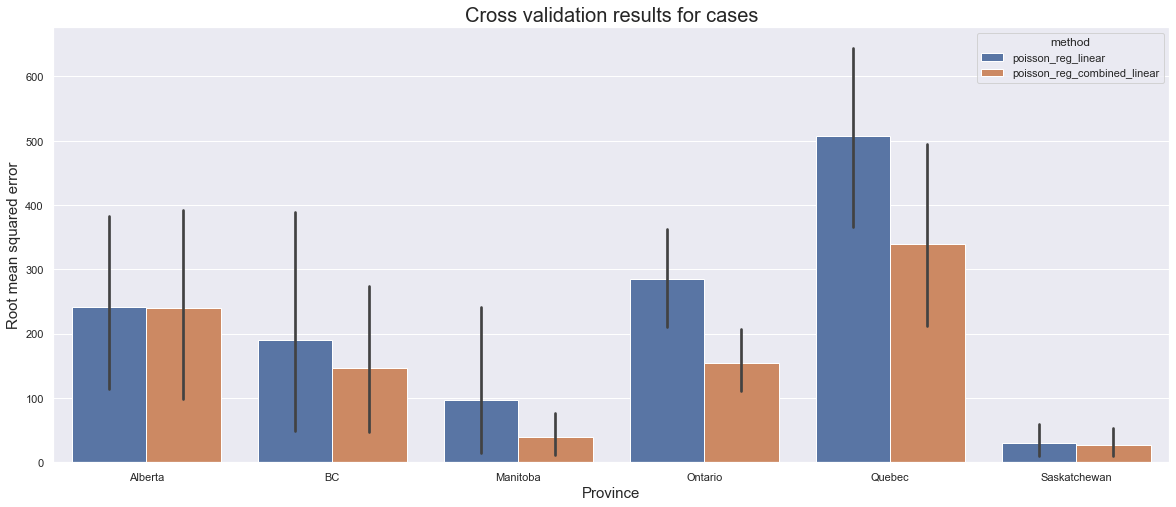

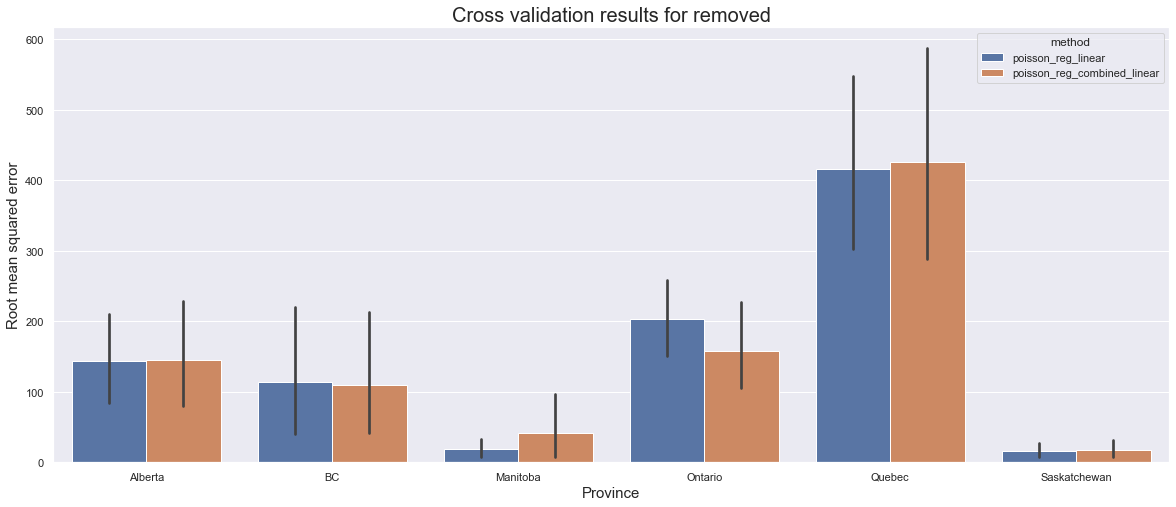

In [152]:
# Barplots for cross val scores across each province per method

fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="province", y="rmse", hue="method", data=cv_scores.query('response == "cases"'))
t = ax.set_title("Cross validation results for cases", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="province", y="rmse", hue="method", data=cv_scores.query('response == "removed"'))
t = ax.set_title("Cross validation results for removed", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

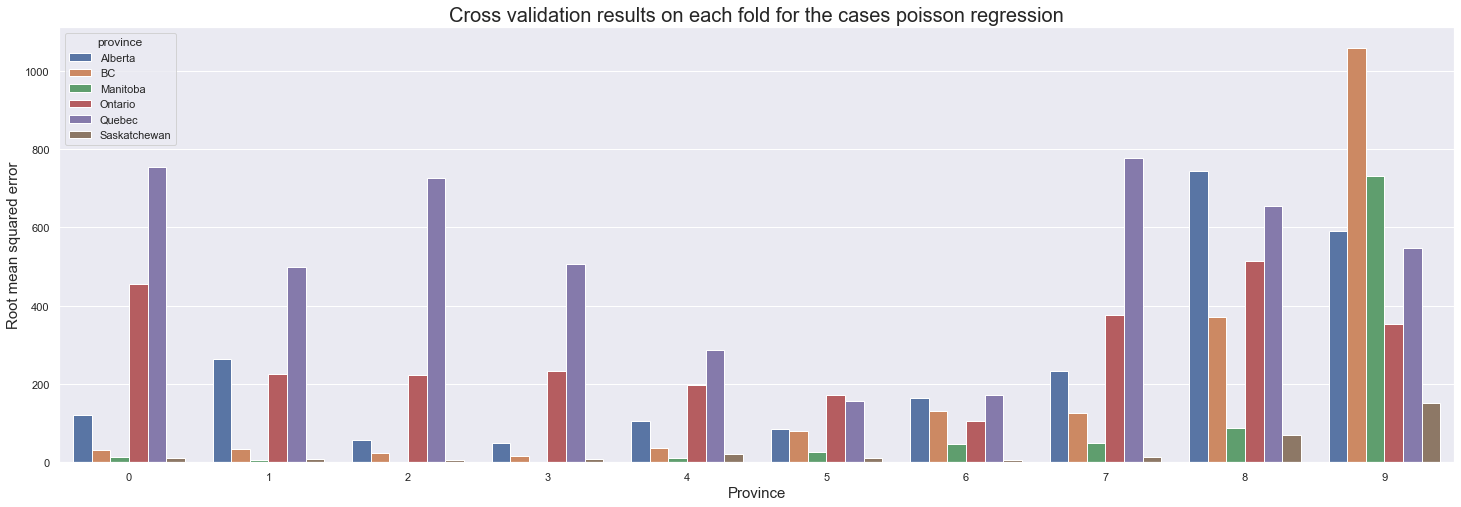

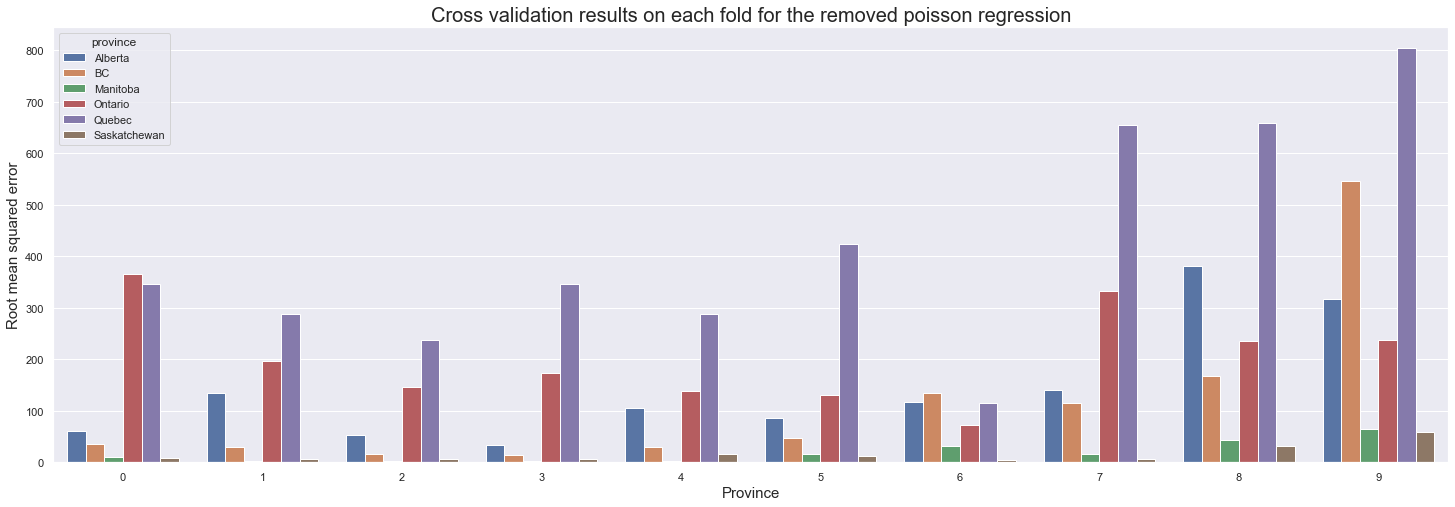

In [153]:
# Individual k fold scores

fig = plt.figure(figsize=(25, 8))
ax = sns.barplot(
    x="fold", y="rmse", hue="province", data=cv_scores.query('method == "poisson_reg_linear" and response == "cases"')
)
t = ax.set_title("Cross validation results on each fold for the cases poisson regression", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

fig = plt.figure(figsize=(25, 8))
ax = sns.barplot(
    x="fold", y="rmse", hue="province", data=cv_scores.query('method == "poisson_reg_linear" and response == "removed"')
)
t = ax.set_title("Cross validation results on each fold for the removed poisson regression", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

### Comments

- Overall the results are pretty bad for each province and rmse is much too high. Looking at the k fold test scores it seems like the fold rmse is higher near the start which makes sense as there is not much data to train on, but also near the end as the government interventions changed and there was an increase in cases
- Currently the linear poisson regression model seems too simple and makes large errors due to not being able to account for government intervention